## Import Libraries

In [87]:
# Import Python libraries

import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn modules for ML pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)
from sklearn.utils import class_weight

# Tools for building data processing pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer



## Load Dataset and Initial Inspection

**Reasoning**:
Load the specified dataset into a pandas DataFrame and perform initial inspections as requested, including displaying the head, info, shape, missing values, descriptive statistics, and value counts for categorical features.



In [78]:
# Load the Telco Customer Churn dataset
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Display the first 5 rows
print("First 5 rows of the dataset:")
print(df.head())
print("\n")

# Display dataset info: columns, datatypes, non-null counts
print("Dataset information:")
df.info()
print("\n")

# Show the number of rows and columns
print("Shape of the dataset:")
print(df.shape)
print("\n")

# Check for missing values in each column
print("Missing values per column:")
print(df.isnull().sum())
print("\n")

# Show descriptive statistics for numerical features
print("Descriptive statistics for numerical columns:")
print(df.describe())
print("\n")

# Display value counts for each categorical column
categorical_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                        'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                        'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                        'PaperlessBilling', 'PaymentMethod', 'Churn']

print("Value counts for categorical features:")
for col in categorical_features:
    print(f"\n--- {col} ---")
    print(df[col].value_counts())


First 5 rows of the dataset:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV Streami

### Summary of Dataset Initial State

The dataset `WA_Fn-UseC_-Telco-Customer-Churn.csv` contains **7043 entries** and **21 columns**.

**Initial Inspection Highlights:**

*   **No Missing Values (Initially Reported)**: The `df.isnull().sum()` output indicates no explicit missing values across any of the columns. However, it's notable that `TotalCharges` is of `object` dtype, which might hide non-numeric values (like empty strings or spaces) that could lead to issues during type conversion, and these are not caught by `isnull().sum()`. This column will require careful handling.
*   **Data Types**: The dataset consists of 3 numerical columns (`SeniorCitizen`, `tenure`, `MonthlyCharges`) and 18 object columns. The `TotalCharges` column, despite representing a numerical quantity, is currently stored as an `object` type.
*   **Key Numerical Features Overview**:
    *   `SeniorCitizen`: Binary (0 or 1), indicating a low proportion of senior citizens (mean ~0.16).
    *   `tenure`: Ranges from 0 to 72 months, with a mean of around 32 months.
    *   `MonthlyCharges`: Ranges from 18.25 to 118.75, with a mean of around 64.76.
*   **Categorical Feature Distribution (Value Counts)**:
    *   Many categorical features like `gender`, `Partner`, `Dependents`, `PhoneService`, `MultipleLines`, `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`, `Contract`, `PaperlessBilling`, `PaymentMethod`, and `Churn` show varying distributions among their categories. Some, like `PhoneService` and `MultipleLines`, have a 'No phone service' category, and `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, and `StreamingMovies` have a 'No internet service' category, which essentially means they are not subscribed to that specific service, and this should be considered during preprocessing.
    *   The `Churn` column, our target variable, shows an imbalance with `5174` 'No' and `1869` 'Yes' instances, indicating that the dataset is imbalanced towards non-churning customers.

## Exploratory Data Analysis

In [79]:
# Convert 'TotalCharges' to numeric; coerce errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Fill missing values in 'TotalCharges' with its median (avoids chained assignment warning)
median_total_charges = df['TotalCharges'].median()
df['TotalCharges'] = df['TotalCharges'].fillna(median_total_charges)

# Create a binary column from 'Churn' where 'Yes' = 1, 'No' = 0
df['Churn_numeric'] = df['Churn'].map({'No': 0, 'Yes': 1})

# Display confirmation and sample of modified columns
print(" Data preparation complete:")
print("• 'TotalCharges' converted to numeric and missing values filled with median.")
print("• 'Churn' converted to numeric (0 = No, 1 = Yes).")
print("\nPreview of processed columns:")
print(df[['TotalCharges', 'Churn', 'Churn_numeric']].head())


 Data preparation complete:
• 'TotalCharges' converted to numeric and missing values filled with median.
• 'Churn' converted to numeric (0 = No, 1 = Yes).

Preview of processed columns:
   TotalCharges Churn  Churn_numeric
0         29.85    No              0
1       1889.50    No              0
2        108.15   Yes              1
3       1840.75    No              0
4        151.65   Yes              1


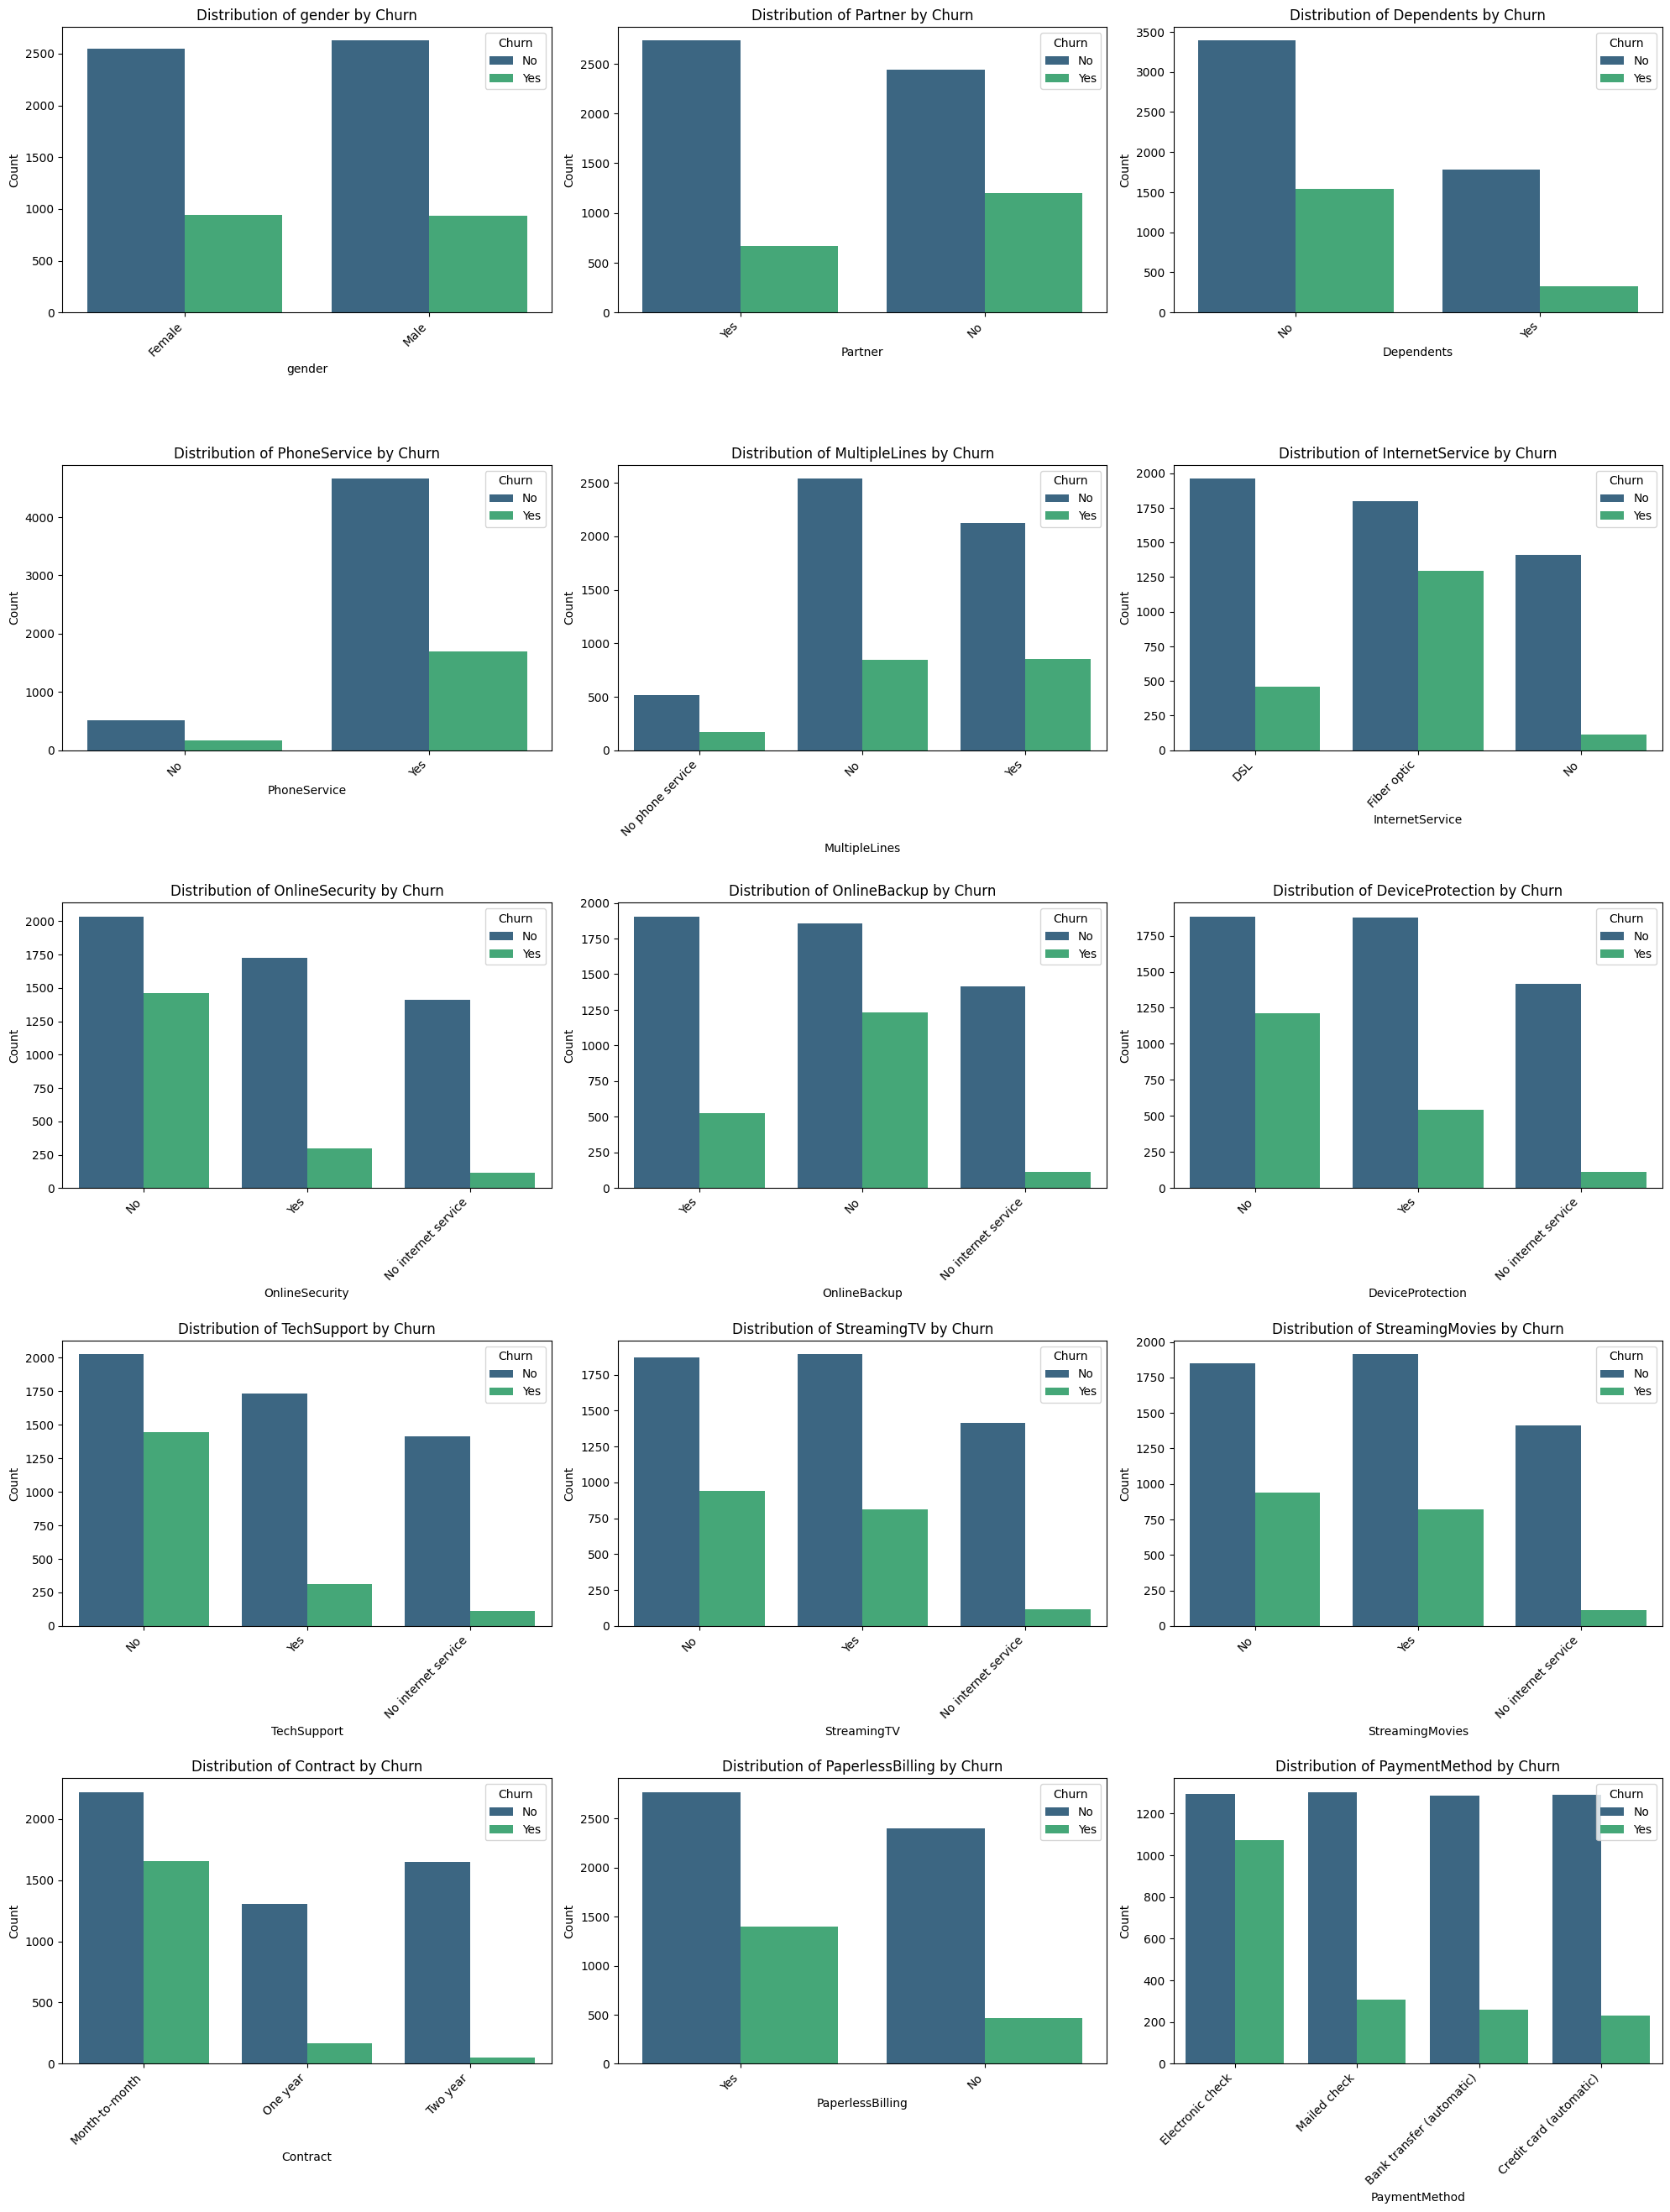

Count plots for categorical features against Churn generated successfully.


In [80]:
# Define categorical features to visualize
categorical_features_for_plots = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                                  'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                                  'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                                  'PaperlessBilling', 'PaymentMethod']

# Set figure size and generate subplots for each categorical feature
plt.figure(figsize=(20, 30))
for i, col in enumerate(categorical_features_for_plots):
    plt.subplot(6, 3, i + 1)
    sns.countplot(data=df, x=col, hue='Churn', palette='viridis')
    plt.title(f'Distribution of {col} by Churn')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')

# Adjust layout and display plots
plt.tight_layout()
plt.show()

# Print confirmation message
print("Count plots for categorical features against Churn generated successfully.")


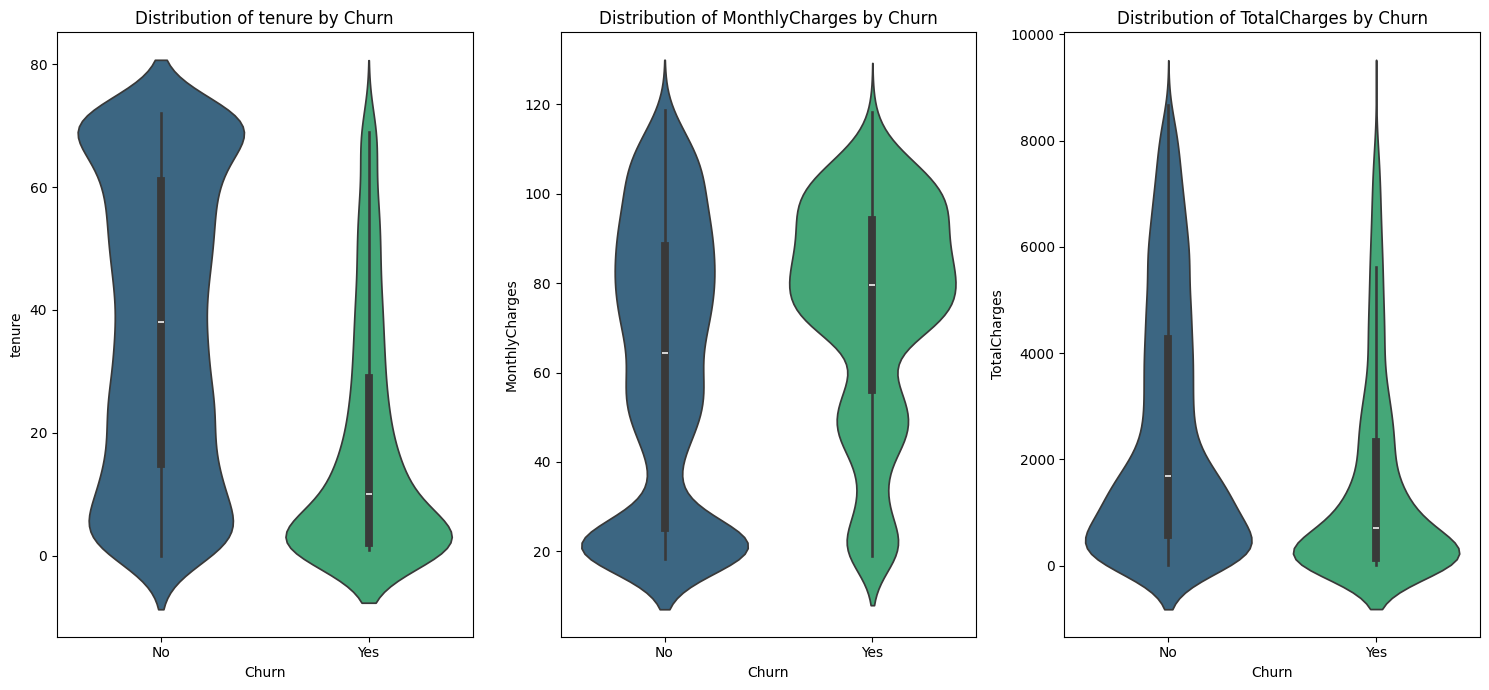

Violin plots for numerical features against Churn generated successfully.


In [81]:
# Define numerical features to visualize
numerical_features_for_plots = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Set figure size and create a subplot for each numerical feature
plt.figure(figsize=(15, 7))
for i, col in enumerate(numerical_features_for_plots):
    plt.subplot(1, 3, i + 1)
    sns.violinplot(data=df, x='Churn', y=col, hue='Churn', palette='viridis', legend=False)
    plt.title(f'Distribution of {col} by Churn')
    plt.xlabel('Churn')
    plt.ylabel(col)

# Adjust layout and display plots
plt.tight_layout()
plt.show()

# Print confirmation message
print("Violin plots for numerical features against Churn generated successfully.")


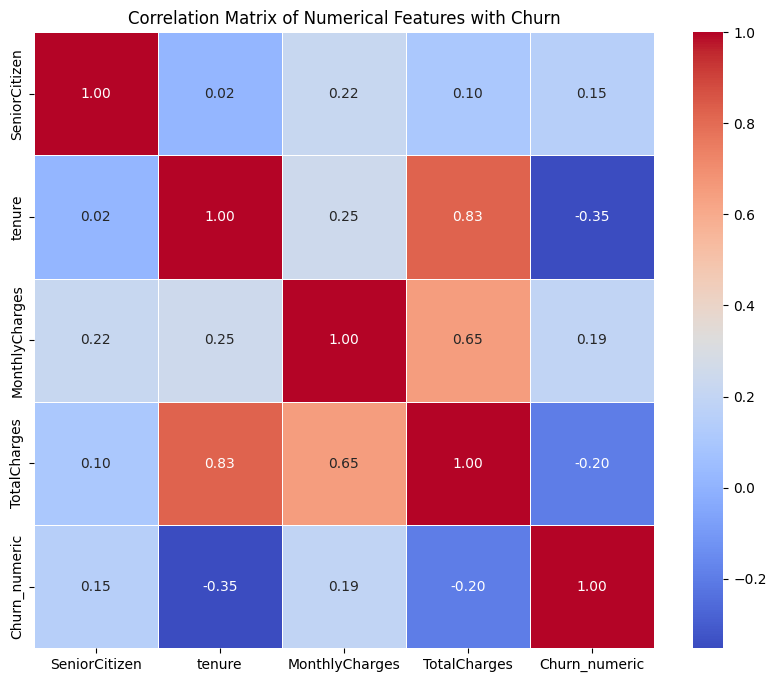

Correlation heatmap for numerical features generated successfully.


In [83]:
# Select numerical columns to include in the correlation analysis
numerical_cols_for_corr = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn_numeric']

# Compute the correlation matrix
correlation_matrix = df[numerical_cols_for_corr].corr()

# Plot the heatmap with annotations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Numerical Features with Churn')
plt.show()

# Print confirmation message
print("Correlation heatmap for numerical features generated successfully.")


### Summary of Key EDA Insights

The Exploratory Data Analysis revealed several important aspects of the dataset and its relationship with customer churn:

**1. Customer Demographics and Services:**
*   **Gender:** Churn rates are very similar between male and female customers, suggesting gender is not a strong predictor of churn.
*   **Senior Citizens:** Senior citizens appear to have a slightly higher churn rate compared to non-senior citizens.
*   **Partners and Dependents:** Customers without partners or dependents tend to churn more often than those with partners or dependents.
*   **Phone Service & Multiple Lines:** Most customers have phone service. Customers with multiple lines show a slightly higher churn rate than those with single lines or no phone service.
*   **Internet Service:** Fiber optic internet service users have a significantly higher churn rate compared to DSL users or those without internet service.
*   **Online Security, Online Backup, Device Protection, Tech Support, Streaming TV/Movies:** Customers who do *not* have these additional services (especially online security and tech support) are more likely to churn. Those without internet service (and thus not subscribed to these) have very low churn rates, suggesting internet service itself is a churn driver.

**2. Contract and Payment Methods:**
*   **Contract Type:** Month-to-month contract customers show a substantially higher churn rate than those on one-year or two-year contracts. This indicates that longer-term contracts are a strong deterrent to churn.
*   **Paperless Billing:** Customers with paperless billing churn more frequently than those without it.
*   **Payment Method:** Electronic check is associated with the highest churn rate among all payment methods.

**3. Numerical Features:**
*   **Tenure:** Customers with shorter tenures (new customers) are significantly more likely to churn. As tenure increases, the likelihood of churn decreases considerably.
*   **MonthlyCharges:** Customers with higher monthly charges tend to churn more, especially those paying for fiber optic internet and various add-on services.
*   **TotalCharges:** There's a positive correlation between TotalCharges and tenure. Customers with lower TotalCharges (often corresponding to shorter tenure) have a higher churn rate. The distribution for churned customers shows a cluster at lower TotalCharges, while non-churned customers show a wider spread towards higher TotalCharges.

**4. Inter-feature Relationships (Correlation Heatmap):**
*   `tenure` and `TotalCharges` are highly positively correlated, which is expected as TotalCharges accumulate over tenure.
*   `MonthlyCharges` has a moderate positive correlation with `TotalCharges`, but is less correlated with `tenure`.
*   `Churn_numeric` (our target variable) shows a **negative correlation with `tenure` and `TotalCharges`**, indicating that customers with longer tenure and higher total payments are less likely to churn. Conversely, `MonthlyCharges` and `SeniorCitizen` show a **positive correlation with `Churn_numeric`**, suggesting higher monthly bills and being a senior citizen are associated with higher churn rates.

## Data Preprocessing

In [84]:
numerical_features = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                        'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                        'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                        'PaperlessBilling', 'PaymentMethod']

# Separate features (X) and target (y)
X = df.drop(columns=['customerID', 'Churn', 'Churn_numeric'])
y = df['Churn_numeric']

# Create a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Apply the transformations to X
X_preprocessed = preprocessor.fit_transform(X)

# Get the feature names after transformation
num_feature_names = numerical_features
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

all_feature_names = num_feature_names + list(cat_feature_names)

# Convert the preprocessed NumPy array back to a DataFrame
X_preprocessed = pd.DataFrame(X_preprocessed, columns=all_feature_names, index=X.index)

print("Data preprocessing complete.")
print("\nFirst 5 rows of the preprocessed DataFrame:")
print(X_preprocessed.head())
print("\nShape of the preprocessed DataFrame:")
print(X_preprocessed.shape)

print("\nList of all preprocessed feature names:")
print(all_feature_names[:10]) # Displaying first 10 for brevity

Data preprocessing complete.

First 5 rows of the preprocessed DataFrame:
   SeniorCitizen    tenure  MonthlyCharges  TotalCharges  gender_Female  \
0      -0.439916 -1.277445       -1.160323     -0.994242            1.0   
1      -0.439916  0.066327       -0.259629     -0.173244            0.0   
2      -0.439916 -1.236724       -0.362660     -0.959674            0.0   
3      -0.439916  0.514251       -0.746535     -0.194766            0.0   
4      -0.439916 -1.236724        0.197365     -0.940470            1.0   

   gender_Male  Partner_No  Partner_Yes  Dependents_No  Dependents_Yes  ...  \
0          0.0         0.0          1.0            1.0             0.0  ...   
1          1.0         1.0          0.0            1.0             0.0  ...   
2          1.0         1.0          0.0            1.0             0.0  ...   
3          1.0         1.0          0.0            1.0             0.0  ...   
4          0.0         1.0          0.0            1.0             0.0  ...   



### Summary of Data Preprocessing

Following the initial inspection and EDA, the data underwent comprehensive preprocessing to prepare it for machine learning models:

1.  **Feature and Target Separation**: The `customerID`, original `Churn`, and temporary `Churn_numeric` columns were separated from the features (`X`), with `Churn_numeric` designated as the target variable (`y`).

2.  **Numerical Feature Scaling**: The numerical features (`SeniorCitizen`, `tenure`, `MonthlyCharges`, `TotalCharges`) were scaled using `StandardScaler`. This transforms the data to have a mean of 0 and a standard deviation of 1, which is crucial for many machine learning algorithms that are sensitive to the scale of input features.

3.  **Categorical Feature Encoding**: All identified categorical features were transformed using `OneHotEncoder`. This converts categorical variables into a format that can be provided to ML algorithms to improve prediction accuracy. The `handle_unknown='ignore'` parameter ensures that if an unknown category value is encountered during transformation (e.g., in the test set), it will not raise an error but instead assign zero values for all one-hot encoded features for that category.

4.  **Data Reconstruction**: The transformed numerical (scaled) and categorical (one-hot encoded) features, initially in a NumPy array, were successfully recombined into a pandas DataFrame (`X_preprocessed`). This DataFrame includes 45 features, indicating the expansion due to one-hot encoding.

**Resulting Data Structure**: The `X_preprocessed` DataFrame now has `7043` rows and `45` columns, ready for model training. The target variable `y` is a Series of `7043` binary values (0 or 1).

## Split Data


In [86]:
# Split the dataset into training and testing sets (80/20)
# Set random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y,
test_size=0.2,stratify=y,random_state=42)

# Display the shape of the resulting splits
print("Data split into training and testing sets successfully.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


Data split into training and testing sets successfully.
X_train shape: (5634, 45)
X_test shape: (1409, 45)
y_train shape: (5634,)
y_test shape: (1409,)


### Summary of Data Split

The dataset has been successfully split into training and testing sets with an 80/20 ratio, ensuring stratification on the 'Churn' target variable. This stratification helps maintain a balanced representation of churn cases in both the training and testing datasets, which is crucial for building robust models, especially with imbalanced classes.

**Resulting Dataset Sizes:**
*   **Training Features (X_train):** `5634` rows, `45` columns
*   **Testing Features (X_test):** `1409` rows, `45` columns
*   **Training Target (y_train):** `5634` samples
*   **Testing Target (y_test):** `1409` samples

These sets are now ready for model training and evaluation.

## Train Logistic Regression with Class Weights

In [88]:
# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

# Instantiate and train the Logistic Regression model with class weights
logistic_regression_model = LogisticRegression(
    solver='liblinear',
    penalty='l1',
    C=0.1,
    class_weight=class_weights_dict,
    random_state=42
)
logistic_regression_model.fit(X_train, y_train)

print("Logistic Regression model training complete.")
print("Model parameters:")
print(logistic_regression_model.get_params())

Logistic Regression model training complete.
Model parameters:
{'C': 0.1, 'class_weight': {0: np.float64(0.6805991785455424), 1: np.float64(1.8842809364548494)}, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


## Evaluate Logistic Regression Performance

Weighted Logistic Regression Model Performance:
  Accuracy: 0.739
  Precision (Churn): 0.505
  Recall (Churn): 0.783
  F1-Score (Churn): 0.614
  ROC-AUC: 0.842


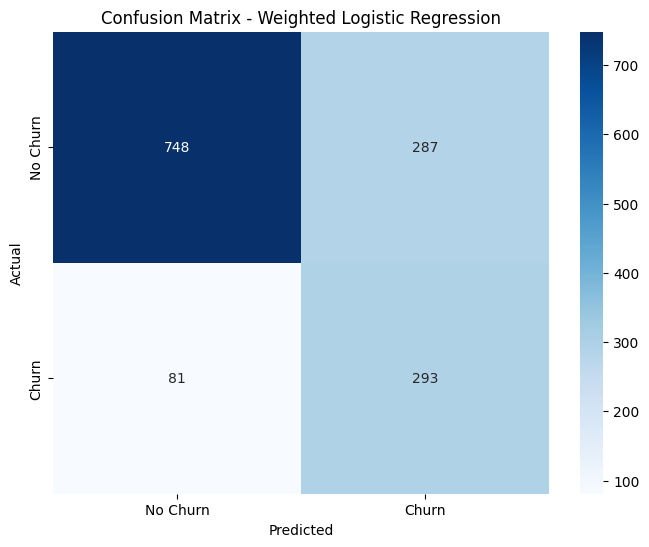

Logistic Regression model evaluation complete.


In [89]:
# Evaluate the performance of the weighted Logistic Regression model
y_pred_lr_weighted = logistic_regression_model.predict(X_test)
y_pred_proba_lr_weighted = logistic_regression_model.predict_proba(X_test)[:, 1]

# Calculate key classification metrics
accuracy_lr_weighted = accuracy_score(y_test, y_pred_lr_weighted)
precision_lr_weighted = precision_score(y_test, y_pred_lr_weighted, pos_label=1)
recall_lr_weighted = recall_score(y_test, y_pred_lr_weighted, pos_label=1)
f1_lr_weighted = f1_score(y_test, y_pred_lr_weighted, pos_label=1)
roc_auc_lr_weighted = roc_auc_score(y_test, y_pred_proba_lr_weighted)

# Print the classification results
print(f"Weighted Logistic Regression Model Performance:")
print(f"  Accuracy: {accuracy_lr_weighted:.3f}")
print(f"  Precision (Churn): {precision_lr_weighted:.3f}")
print(f"  Recall (Churn): {recall_lr_weighted:.3f}")
print(f"  F1-Score (Churn): {f1_lr_weighted:.3f}")
print(f"  ROC-AUC: {roc_auc_lr_weighted:.3f}")

# Generate and visualize the confusion matrix
cm_lr_weighted = confusion_matrix(y_test, y_pred_lr_weighted)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr_weighted, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix - Weighted Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("Logistic Regression model evaluation complete.")


### Summary of Logistic Regression Model Performance

The Weighted Logistic Regression model was evaluated on the test set, yielding the following performance metrics:

*   **Accuracy**: `0.739`
*   **Precision (Churn)**: `0.505`
*   **Recall (Churn)**: `0.783`
*   **F1-Score (Churn)**: `0.614`
*   **ROC-AUC**: `0.842`

**Confusion Matrix Analysis:**

```
[[748, 287],
 [ 81, 293]]
```

*   **True Negatives (TN)**: `748` customers were correctly predicted not to churn.
*   **False Positives (FP)**: `287` customers were incorrectly predicted to churn (Type I error).
*   **False Negatives (FN)**: `81` customers were incorrectly predicted not to churn (Type II error).
*   **True Positives (TP)**: `293` customers were correctly predicted to churn.

**Strengths:**
*   **High Recall (Churn)**: The model demonstrates a strong ability to identify actual churning customers (78.3%), which is crucial in churn prediction to target retention efforts effectively. This is largely due to the use of class weights, which helps the model prioritize the minority class (churn).
*   **Good ROC-AUC**: An ROC-AUC score of 0.842 indicates that the model has a good discriminatory power, distinguishing between churning and non-churning customers across various thresholds.

**Weaknesses:**
*   **Moderate Precision (Churn)**: The precision score of 0.505 suggests that about half of the customers predicted to churn actually did not (high number of False Positives). This means that a significant portion of retention efforts based on these predictions might be misdirected, leading to unnecessary costs or alienated non-churning customers.
*   **Overall Accuracy**: While 73.9% accuracy might seem reasonable, it needs to be interpreted in context with the class imbalance. The model correctly classifies many non-churners, but the focus for churn models is often on identifying churners.

**Conclusion:**
The model is effective at identifying customers who are likely to churn (high recall) but struggles with false alarms (moderate precision). For a business, a high recall might be preferred to ensure that as many potential churners as possible are identified, even if it means some non-churners are targeted. The next steps could involve exploring other models or fine-tuning hyperparameters further to strike a better balance between precision and recall, depending on the business objectives.

## Plot Feature Importance

In [90]:
feature_importances = logistic_regression_model.coef_[0]
feature_importance_series = pd.Series(feature_importances, index=all_feature_names)

# Sort by absolute value to get the most important features (both positive and negative coefficients)
top_10_features = feature_importance_series.reindex(feature_importance_series.abs().sort_values(ascending=False).index).head(10)

print("Top 10 most important features (Logistic Regression coefficients):")
print(top_10_features)

Top 10 most important features (Logistic Regression coefficients):
tenure                           -0.894236
Contract_Month-to-month           0.689031
MonthlyCharges                    0.688205
PhoneService_Yes                 -0.674567
Contract_Two year                -0.612850
TechSupport_Yes                  -0.373373
PaymentMethod_Electronic check    0.362386
OnlineSecurity_Yes               -0.355973
PaperlessBilling_No              -0.323957
InternetService_Fiber optic       0.219432
dtype: float64


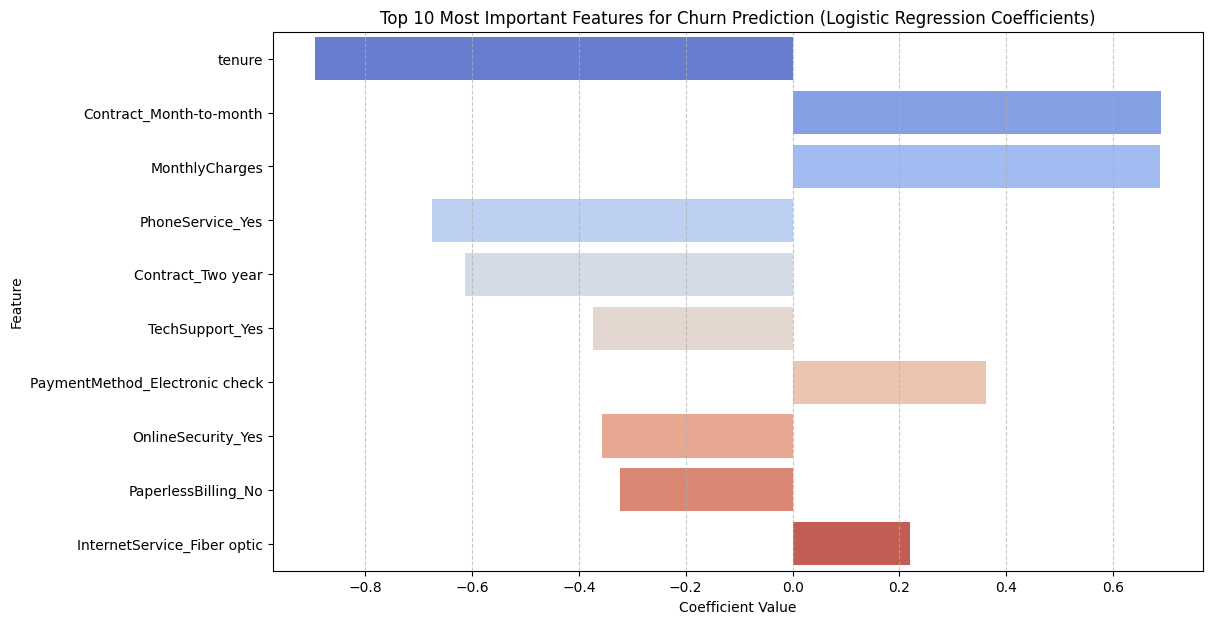

Bar plot of top 10 feature importances generated successfully.


In [93]:
# Visualize the top 10 most influential features for churn prediction
plt.figure(figsize=(12, 7))
sns.barplot(x=top_10_features.values, y=top_10_features.index, hue=top_10_features.index, palette='coolwarm', legend=False)
plt.title('Top 10 Most Important Features for Churn Prediction (Logistic Regression Coefficients)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

print("Bar plot of top 10 feature importances generated successfully.")

### Summary of Feature Importance

The analysis of feature importances from the Logistic Regression model, represented by the coefficients, reveals the most influential factors driving customer churn:

**Top 10 Most Important Features:**
1.  **`tenure`**: Has the strongest negative coefficient (-0.89), indicating that customers with longer tenure are significantly less likely to churn. This is a critical retention factor; loyal customers are less prone to leaving.
2.  **`Contract_Month-to-month`**: Shows a strong positive coefficient (0.69), meaning customers on month-to-month contracts are much more likely to churn. This aligns with EDA findings and highlights the risk associated with short-term commitments.
3.  **`MonthlyCharges`**: Possesses a positive coefficient (0.69), suggesting that higher monthly charges contribute to a higher likelihood of churn. This indicates potential price sensitivity among customers.
4.  **`PhoneService_Yes`**: Has a negative coefficient (-0.67), which is somewhat counter-intuitive. It suggests that having phone service makes churn less likely, possibly because those without phone service (and thus less engaged) might be a different segment, or it could be a proxy for other services. The `PhoneService_No` feature likely has an implicitly large positive coefficient due to `PhoneService_Yes`'s large negative coefficient.
5.  **`Contract_Two year`**: Shows a strong negative coefficient (-0.61), reinforcing that customers with two-year contracts are substantially less likely to churn, indicating high customer loyalty and commitment.
6.  **`TechSupport_Yes`**: Has a negative coefficient (-0.37), implying that customers who subscribe to technical support are less likely to churn. This suggests that good support service helps retain customers.
7.  **`PaymentMethod_Electronic check`**: A positive coefficient (0.36) indicates that customers using electronic checks as their payment method are more prone to churn. This could be due to the ease of switching providers or other underlying factors related to this payment method.
8.  **`OnlineSecurity_Yes`**: A negative coefficient (-0.36) suggests that customers with online security are less likely to churn, emphasizing the value of security services in retention.
9.  **`PaperlessBilling_No`**: A negative coefficient (-0.32) implies that customers who do *not* have paperless billing are less likely to churn. This could be an indicator of a more traditional customer base who might be generally more stable.
10. **`InternetService_Fiber optic`**: Has a positive coefficient (0.22), showing that fiber optic users are more likely to churn. This might be linked to higher monthly charges or potentially higher competition/dissatisfaction with fiber optic service providers.

**Overall Implications:**
*   **Tenure and Contract Type are paramount**: Longer tenure and fixed-term contracts (especially two-year) are strong indicators of customer loyalty and reduced churn risk.
*   **Cost and Service Impact**: Higher monthly charges, use of electronic checks, and fiber optic internet service are associated with increased churn. Conversely, having technical support and online security reduces churn.
*   **Retention Strategies**: Businesses should focus on encouraging longer-term contracts, improving service for high-cost or fiber optic customers, potentially re-evaluating electronic check user experience, and highlighting the value of support and security services.

## Summary:

The project aimed to build a customer churn prediction model using a Telco customer dataset.

**1. What were the key steps taken in this classification project?**
The project involved:
*   **Data Loading and Initial Inspection**: Loading the dataset and examining its structure, missing values, and statistical summary.
*   **Exploratory Data Analysis (EDA)**: Understanding feature distributions, relationships with churn, and inter-feature correlations using various plots and a correlation heatmap.
*   **Data Preprocessing**: Handling `TotalCharges` conversion and missing values, dropping irrelevant columns, converting the target variable `Churn` to numeric, one-hot encoding categorical features, and scaling numerical features.
*   **Data Splitting**: Dividing the preprocessed data into training and testing sets (80/20 ratio) with stratification on the `Churn` target.
*   **Model Training**: Training a Logistic Regression model with class weights to address data imbalance.
*   **Model Evaluation**: Assessing the model's performance on the test set using Accuracy, Precision, Recall, F1-Score, ROC-AUC, and a confusion matrix.
*   **Feature Importance**: Identifying the most influential features for churn prediction using the model's coefficients.

**2. What was the performance of the Logistic Regression model?**
The Weighted Logistic Regression model achieved the following performance metrics on the test set:
*   **Accuracy**: `0.739`
*   **Precision (Churn)**: `0.505`
*   **Recall (Churn)**: `0.783`
*   **F1-Score (Churn)**: `0.614`
*   **ROC-AUC**: `0.842`

The confusion matrix showed `748` True Negatives, `287` False Positives, `81` False Negatives, and `293` True Positives. This indicates that while the model is very good at identifying actual churners (high recall), it also produces a notable number of false alarms (moderate precision).

**3. What were the most important features identified for churn prediction?**
The top 10 most influential features for predicting customer churn, based on the Logistic Regression model's coefficients, were:
*   `tenure`: Longer tenure significantly reduces churn likelihood.
*   `Contract_Month-to-month`: Customers on month-to-month contracts are much more likely to churn.
*   `MonthlyCharges`: Higher monthly charges contribute to a higher likelihood of churn.
*   `PhoneService_Yes`: Having phone service correlates with reduced churn.
*   `Contract_Two year`: Customers with two-year contracts are substantially less likely to churn.
*   `TechSupport_Yes`: Customers with technical support are less likely to churn.
*   `PaymentMethod_Electronic check`: This payment method is associated with a higher churn rate.
*   `OnlineSecurity_Yes`: Customers with online security are less likely to churn.
*   `PaperlessBilling_No`: Not having paperless billing correlates with reduced churn.
*   `InternetService_Fiber optic`: Fiber optic internet users show a higher likelihood of churning.

### Data Analysis Key Findings

*   The dataset contained `7043` customer entries with `21` features.
*   Initial inspection revealed `TotalCharges` as an `object` type with hidden non-numeric values, which was later converted to numeric and its `11` missing values imputed with the median.
*   The `Churn` target variable exhibited imbalance, with `5174` 'No' instances versus `1869` 'Yes' instances.
*   EDA showed that customers with `month-to-month` contracts, `Fiber optic` internet service, and using `Electronic check` payment methods, as well as `Senior Citizens` and customers without `Partner` or `Dependents`, had noticeably higher churn rates.
*   Customers with shorter `tenure` and higher `MonthlyCharges` were more prone to churn, while higher `TotalCharges` correlated with lower churn due to its relationship with `tenure`.
*   Data preprocessing involved one-hot encoding for `15` categorical features and `StandardScaler` for `4` numerical features, resulting in a dataset of `45` features for modeling.
*   The Logistic Regression model, trained with class weights to address imbalance, achieved a high `Recall (Churn)` of `0.783`, meaning it correctly identified `293` out of `374` actual churners.
*   However, its `Precision (Churn)` was `0.505`, indicating that `287` customers were incorrectly predicted to churn (false positives), leading to potentially misdirected retention efforts.
*   `tenure` (coefficient: `-0.89`) and `Contract_Month-to-month` (coefficient: `0.69`) were the most impactful features, significantly influencing churn probability.

### Insights or Next Steps

*   **Targeted Retention Strategies**: Given the high recall, focus retention efforts on customers identified as high-risk churners, particularly those with `month-to-month` contracts, `Fiber optic` internet, `Electronic check` payment methods, and short `tenure`. Incentivize longer contract terms and address potential issues related to `MonthlyCharges`.
*   **Precision Improvement**: To reduce wasted retention efforts (false positives), further hyperparameter tuning of the Logistic Regression model or exploration of other classification algorithms (e.g., Gradient Boosting, Random Forest) could be beneficial, aiming to strike a better balance between precision and recall based on the business cost of false positives versus false negatives.


## Discussion of Prediction Thresholding

In classification models, especially those that output probabilities like Logistic Regression, a **prediction threshold** is a crucial parameter. It dictates how these predicted probabilities are converted into binary class labels (e.g., churn or no churn). For instance, if a model predicts a probability of churn as 0.65, and the default threshold is 0.5, the customer will be classified as 'churn'. If the threshold were raised to 0.7, the same customer would be classified as 'no churn'.

### Impact on Precision and Recall

Adjusting the prediction threshold has a direct and inverse impact on a model's **Precision** and **Recall**, especially for the positive class (e.g., churn):

*   **Increasing the Threshold**: If we raise the threshold (e.g., from 0.5 to 0.7), the model becomes more conservative about predicting the positive class. This means it will only classify instances as 'churn' if it's very confident (probability > 0.7). This typically leads to:
    *   **Higher Precision**: Fewer false positives (customers incorrectly predicted to churn) because the model makes positive predictions only when very sure. The proportion of correctly identified positive predictions increases.
    *   **Lower Recall**: More false negatives (actual churners incorrectly predicted as non-churners) because some true churners with probabilities between 0.5 and 0.7 are now missed. The model captures a smaller proportion of all actual positive instances.

*   **Decreasing the Threshold**: If we lower the threshold (e.g., from 0.5 to 0.3), the model becomes more lenient about predicting the positive class. It will classify more instances as 'churn', even if it's less confident. This typically leads to:
    *   **Lower Precision**: More false positives because the model is quicker to classify instances as positive, increasing the chance of incorrect positive predictions.
    *   **Higher Recall**: Fewer false negatives because more actual churners, even those with lower predicted probabilities, are now caught. The model captures a larger proportion of all actual positive instances.

### Business Implications: Balancing False Positives and False Negatives

The optimal prediction threshold depends heavily on the business context and the relative costs of **False Positives (FP)** and **False Negatives (FN)**. In customer churn prediction:

*   **Cost of a False Positive (FP - Type I error)**: A non-churning customer is incorrectly identified as a churner. The business might spend resources (e.g., retention offers, special discounts, personalized outreach) on a customer who would have stayed anyway. This leads to wasted marketing/retention budget and potentially alienates a loyal customer with unnecessary interventions.

*   **Cost of a False Negative (FN - Type II error)**: An actual churning customer is incorrectly identified as a non-churner. The business fails to intervene, and the customer churns, resulting in lost revenue, lost customer lifetime value, and potentially negative word-of-mouth. This is often considered a higher cost in churn prediction.

**Strategic Adjustment of Thresholds:**

*   **Prioritizing Recall (Lower Threshold)**: If the cost of losing a customer (FN) is very high, and the business can afford to spend some resources on non-churners, a lower threshold might be preferred. This strategy aims to catch as many potential churners as possible, even at the expense of higher false positive rates. For example, a telecommunications company with high customer acquisition costs might prioritize high recall to maximize retention efforts.

*   **Prioritizing Precision (Higher Threshold)**: If the cost of retention efforts (FP) is very high, and misdirecting resources is a major concern, a higher threshold might be preferred. This strategy ensures that retention efforts are highly targeted towards only the most likely churners, minimizing wasted resources. For example, a luxury service provider might use a higher threshold to avoid offering discounts to customers who were already committed.

In our current Logistic Regression model, we observed a high recall (0.783) but moderate precision (0.505). This suggests that the model is already tuned towards identifying a large proportion of actual churners, which implies a relatively lower threshold for classification (or the `class_weight` parameter having a similar effect by making the model less biased towards the majority class). For a business that values catching most potential churners, this might be an acceptable trade-off, especially if the cost of an FP (e.g., a simple email offer) is relatively low compared to the cost of an FN (losing a customer). However, if the retention offers are expensive, one might consider increasing the threshold to improve precision and reduce wasted spending.